# Confidence Intervals and Safe Policy Selection

This notebook compares standard confidence intervals with high-confidence
lower bounds and bootstrap intervals.

In [12]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from crl.assumptions import AssumptionSet
from crl.assumptions_catalog import BOUNDED_REWARDS, MARKOV, OVERLAP, SEQUENTIAL_IGNORABILITY
from crl.benchmarks.bandit_synth import SyntheticBandit, SyntheticBanditConfig
from crl.benchmarks.mdp_synth import SyntheticMDP, SyntheticMDPConfig
from crl.estimands.policy_value import PolicyValueEstimand
from crl.estimators.bootstrap import BootstrapConfig
from crl.estimators.fqe import FQEConfig, FQEEstimator
from crl.estimators.high_confidence import HighConfidenceISEstimator
from crl.estimators.importance_sampling import ISEstimator
from crl.viz import configure_notebook_display, save_figure
from crl.viz.plots import plot_estimator_comparison

In [13]:
np.random.seed(0)
configure_notebook_display()

In [14]:
bandit = SyntheticBandit(SyntheticBanditConfig(seed=20))
bandit_data = bandit.sample(num_samples=1_000, seed=21)

bandit_estimand = PolicyValueEstimand(
    policy=bandit.target_policy,
    discount=1.0,
    horizon=1,
    assumptions=AssumptionSet([SEQUENTIAL_IGNORABILITY, OVERLAP, BOUNDED_REWARDS]),
)

is_report = ISEstimator(bandit_estimand).estimate(bandit_data)
hcope_report = HighConfidenceISEstimator(bandit_estimand).estimate(bandit_data)

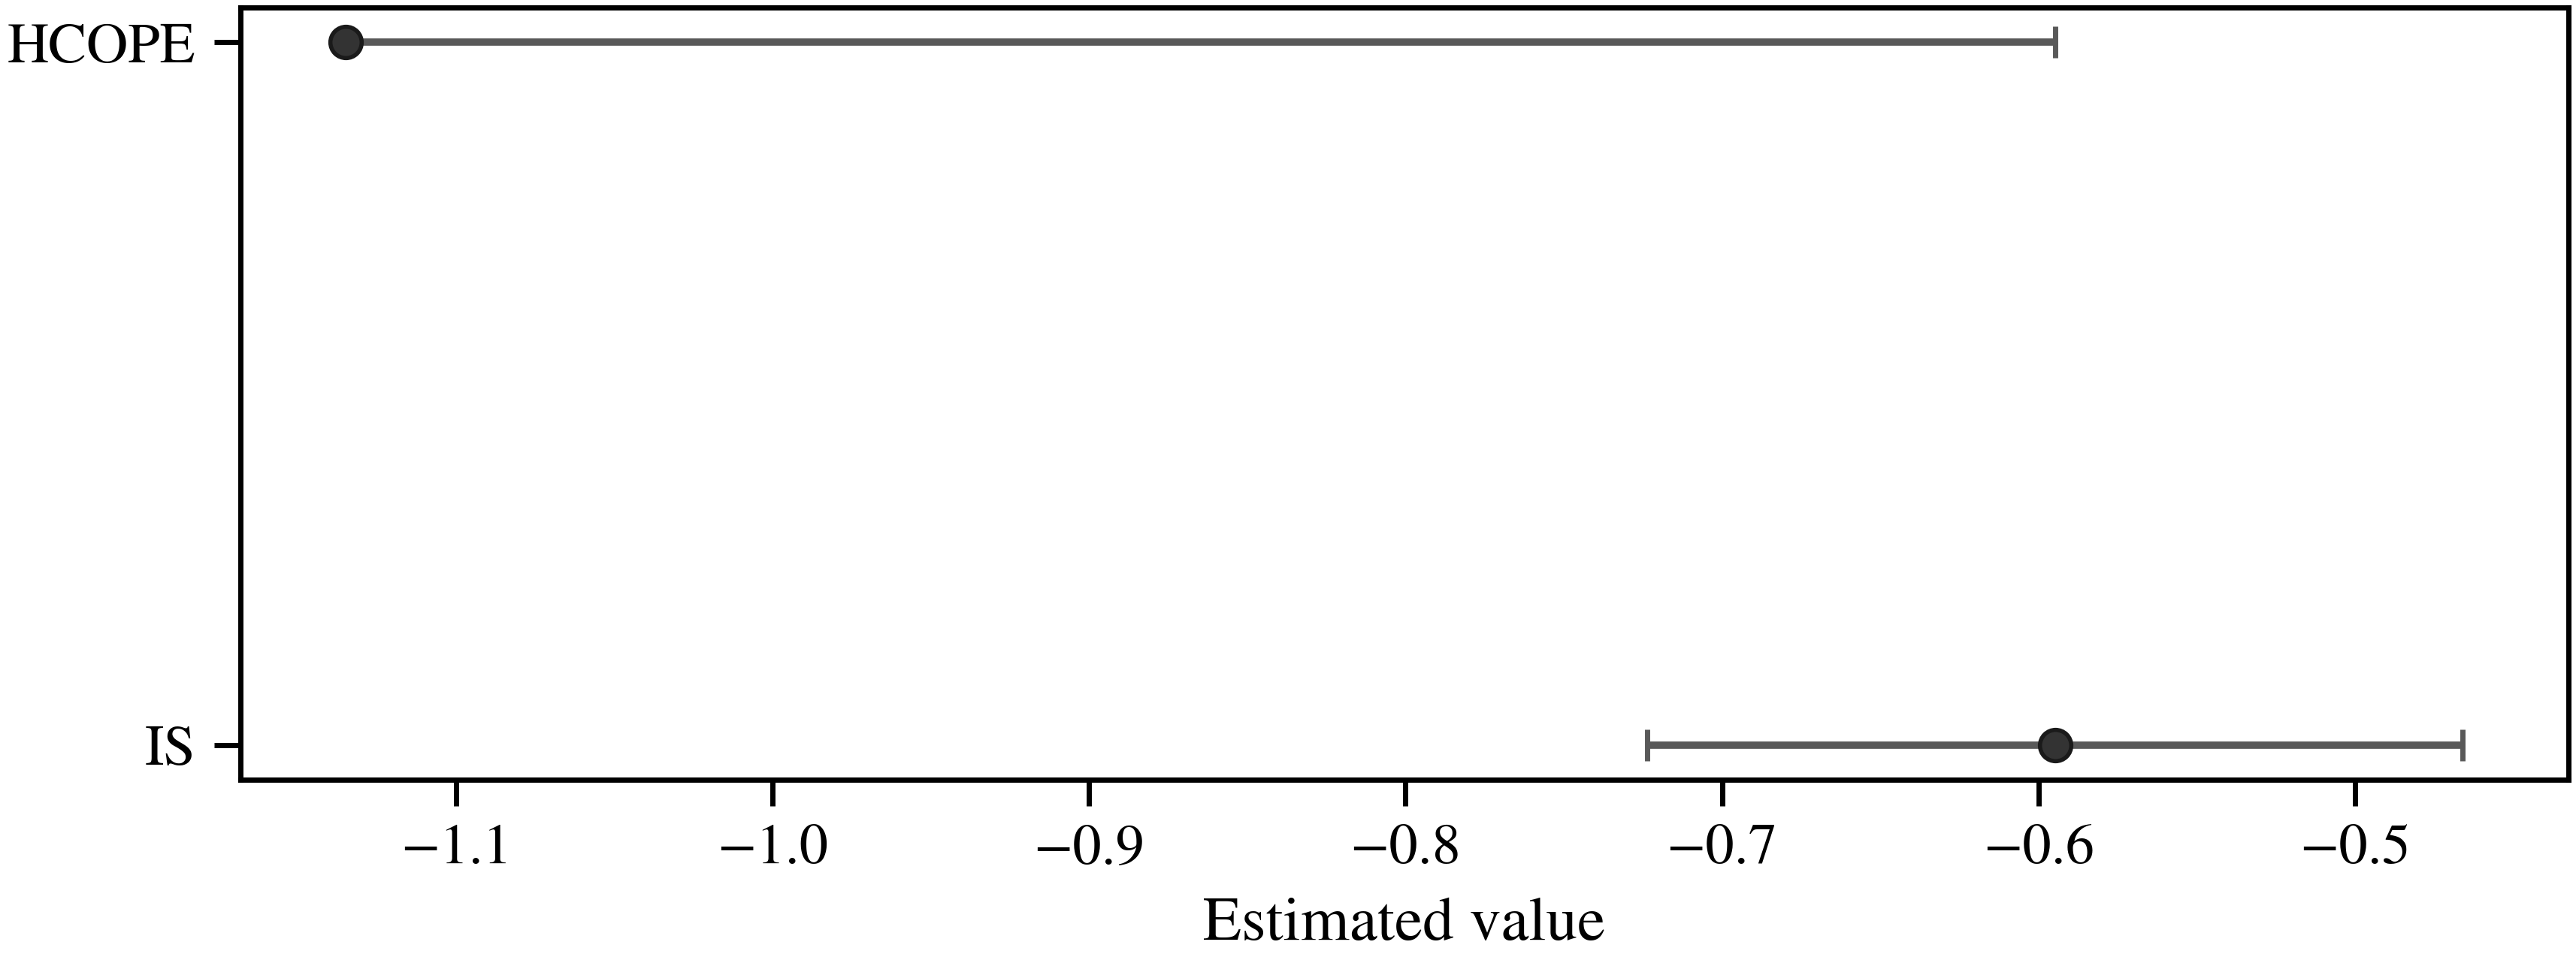

In [15]:
rows = [
    {"estimator": "IS", "value": is_report.value, "ci": is_report.ci},
    {"estimator": "HCOPE", "value": hcope_report.value, "ci": hcope_report.ci},
]
fig_bandit = plot_estimator_comparison(rows)
fig_bandit

In [16]:
mdp = SyntheticMDP(SyntheticMDPConfig(seed=30, horizon=4))
mdp_data = mdp.sample(num_trajectories=60, seed=31)

mdp_estimand = PolicyValueEstimand(
    policy=mdp.target_policy,
    discount=mdp_data.discount,
    horizon=mdp_data.horizon,
    assumptions=AssumptionSet([SEQUENTIAL_IGNORABILITY, OVERLAP, MARKOV]),
)

fqe_config = FQEConfig(
    num_epochs=2,
    num_iterations=2,
    bootstrap=True,
    bootstrap_config=BootstrapConfig(num_bootstrap=20, method="trajectory", seed=2),
)

fqe_report = FQEEstimator(mdp_estimand, config=fqe_config).estimate(mdp_data)

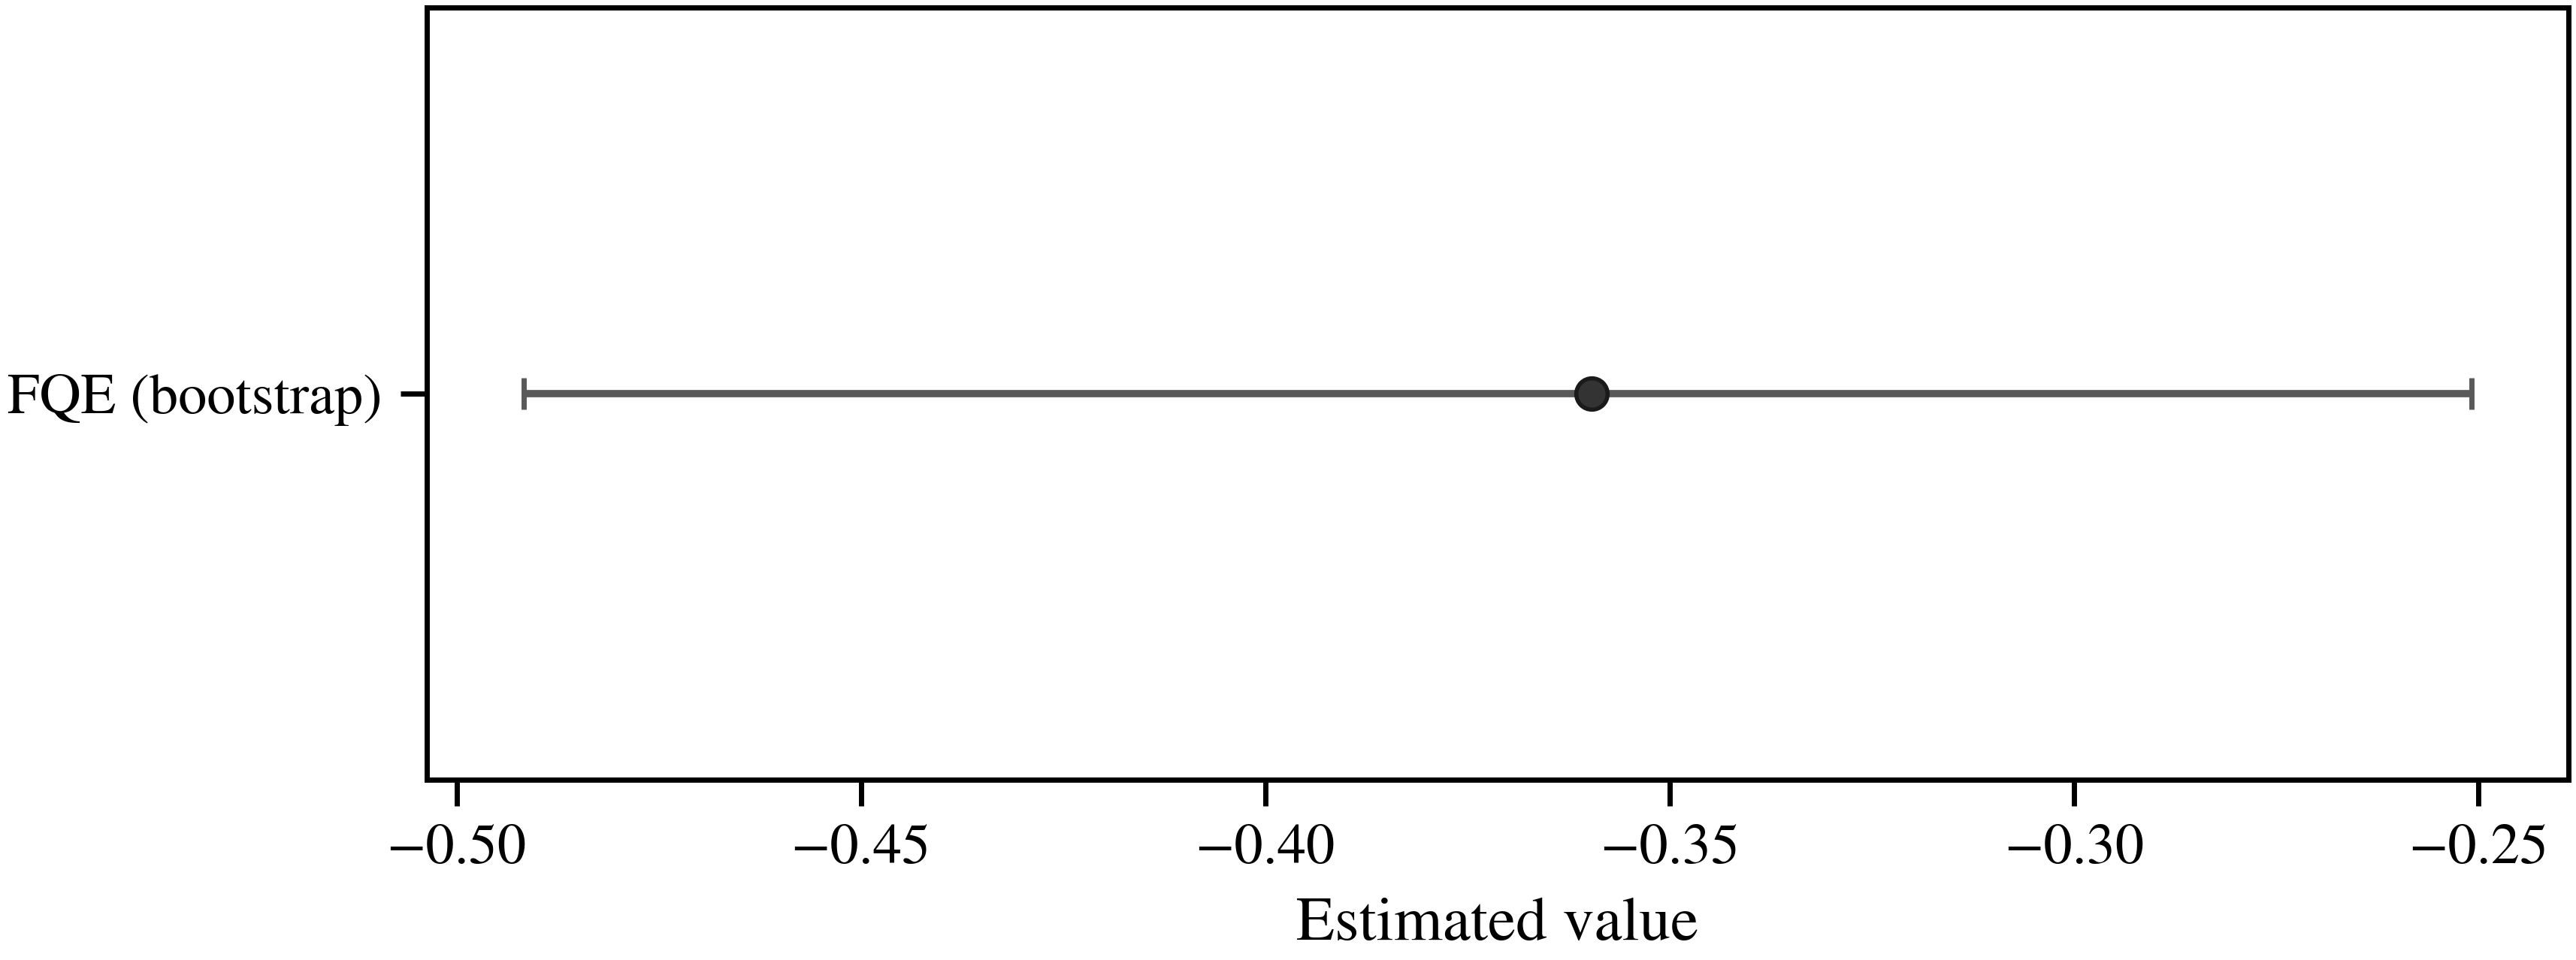

In [17]:
rows = [
    {"estimator": "FQE (bootstrap)", "value": fqe_report.value, "ci": fqe_report.ci},
]
fig_mdp = plot_estimator_comparison(rows)
fig_mdp

In [18]:
output_dir = Path("docs/assets/figures")
output_dir.mkdir(parents=True, exist_ok=True)
save_figure(fig_bandit, output_dir / "ci_bandit_hcope")
save_figure(fig_mdp, output_dir / "ci_mdp_fqe_bootstrap")

{'pdf': 'docs/assets/figures/ci_mdp_fqe_bootstrap.pdf',
 'png': 'docs/assets/figures/ci_mdp_fqe_bootstrap.png'}